In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime as dt
from typing import List, Tuple

In [2]:
data = pd.read_parquet("yellow_tripdata_2019-01.parquet")
data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.50,1.0,N,151,239,1,7.00,0.50,0.5,1.65,0.00,0.3,9.95,NaN,None
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.60,1.0,N,239,246,1,14.00,0.50,0.5,1.00,0.00,0.3,16.30,NaN,None
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.00,1.0,N,236,236,1,4.50,0.50,0.5,0.00,0.00,0.3,5.80,NaN,None
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.00,1.0,N,193,193,2,3.50,0.50,0.5,0.00,0.00,0.3,7.55,NaN,None
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.00,2.0,N,193,193,2,52.00,0.00,0.5,0.00,0.00,0.3,55.55,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7696612,2,2019-01-31 23:37:20,2019-02-01 00:10:43,NaN,10.24,NaN,None,142,95,0,0.00,2.75,0.0,0.00,5.76,0.3,0.00,NaN,None
7696613,2,2019-01-31 23:28:00,2019-01-31 23:50:50,NaN,12.43,NaN,None,48,213,0,48.80,5.50,0.0,0.00,0.00,0.3,54.60,NaN,None
7696614,2,2019-01-31 23:11:00,2019-01-31 23:46:00,NaN,9.14,NaN,None,159,246,0,51.05,2.75,0.5,0.00,0.00,0.3,54.60,NaN,None
7696615,2,2019-01-31 23:03:00,2019-01-31 23:14:00,NaN,0.00,NaN,None,265,265,0,0.00,0.00,0.5,9.82,0.00,0.3,0.00,NaN,None


In [31]:
### Preporcessing ###
df = data.copy()

# cleaning
# imputation
df["passenger_count"].fillna(df["passenger_count"].median(), inplace=True)
df = df[df['RatecodeID'].notna()]
df = df[df['store_and_fwd_flag'].notna()]
df["congestion_surcharge"].fillna(0, inplace=True)
df["airport_fee"].fillna(0, inplace=True)

# feature engeneering

df["trip_time"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
df["weekday"] = df["tpep_pickup_datetime"].dt.dayofweek
df["tpep_pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
df["tpep_pickup_month"] = df["tpep_pickup_datetime"].dt.month
df.drop(columns=["tpep_pickup_datetime", "tpep_dropoff_datetime"], inplace=True)

df["total_amount_per_distance"] = df["total_amount"] / df["trip_distance"]
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df["total_amount_per_distance"].fillna(df["total_amount_per_distance"].mean(), inplace=True)

# outlier removal
continous_data_colums = ["trip_distance", "fare_amount", "fare_amount", "mta_tax", "tip_amount", "extra", "tolls_amount", "tolls_amount", "total_amount", "congestion_surcharge", "airport_fee", "trip_time"]
for col in continous_data_colums:
    df = df[abs(df[col] - df[col].mean()) <= 3 * df[col].std()]
    
# make data numerical
df["trip_time"] = df["trip_time"].dt.total_seconds()
df["store_and_fwd_flag"] = np.where(df["store_and_fwd_flag"]== "N", 0, 1)
    
    
df

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time,weekday,tpep_pickup_hour,tpep_pickup_month,total_amount_per_distance
0,1,1.0,1.50,1.0,0,151,239,1,7.0,0.5,...,0.0,0.3,9.95,0.0,0,400.0,1,0,1,6.633333
1,1,1.0,2.60,1.0,0,239,246,1,14.0,0.5,...,0.0,0.3,16.30,0.0,0,1152.0,1,0,1,6.269231
2,2,3.0,0.00,1.0,0,236,236,1,4.5,0.5,...,0.0,0.3,5.80,0.0,0,250.0,4,13,12,9.584328
3,2,5.0,0.00,1.0,0,193,193,2,3.5,0.5,...,0.0,0.3,7.55,0.0,0,200.0,2,15,11,9.584328
7,1,1.0,1.30,1.0,0,163,229,1,6.5,0.5,...,0.0,0.3,9.05,0.0,0,429.0,1,0,1,6.961538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7667936,2,2.0,4.15,1.0,0,186,13,2,14.5,0.5,...,0.0,0.3,15.80,0.0,0,764.0,3,23,1,3.807229
7667937,2,1.0,1.34,1.0,0,68,233,2,8.0,0.5,...,0.0,0.3,9.30,0.0,0,546.0,3,23,1,6.940299
7667938,2,1.0,1.45,1.0,0,161,229,1,10.5,0.5,...,0.0,0.3,14.16,0.0,0,800.0,3,23,1,9.765517
7667939,2,2.0,4.28,1.0,0,186,262,1,17.0,0.5,...,0.0,0.3,21.96,0.0,0,1122.0,3,23,1,5.130841


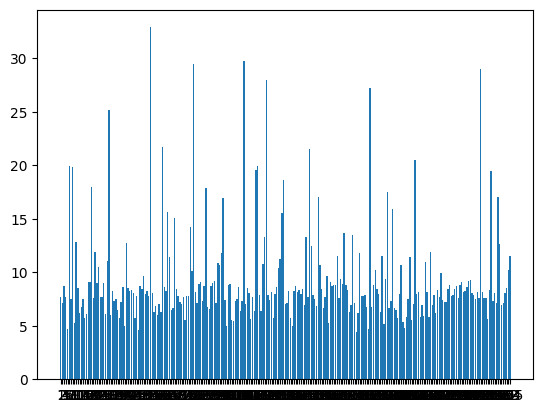

In [4]:
### EDA ###

col = "PULocationID"
x = sorted(list(set(df[col])))
y = [df[df[col] == rid]["total_amount_per_distance"].mean() for rid in x]
x = [str(i) for i in x]
plt.bar(x,y)
plt.show()

In [82]:
### BFR Algorithm ###

# Hyperparams: CLOSE_ENOUGH, CONFIDENCE

# 1. init: kmeans++ with random subsample (choose k)

# 2. LOOP:

# INPUT:
# DS-DiscradSet:  List of k Centroids - List[Tuple[N, SUM, SUMSQ]]
# CS-CompressionSet List of Centroids - List[Tuple[N, SUM, SUMSQ]]
# RS-RetainedSet List of DataPoints

# 2.1 Points CLOSE_ENOUGH to Centroids of DS: update Centroid (and forget Point)
# 2.1 remaining points + RS: build compression sets
# 2.1.1 build clusters with soft kmeans++ with large k -> points with high CONFIDENCE: cluster and new or update CS at the end merge CS, points with low confidence: put into RS

# LAST STEP
# when no data is left: assign all remaing CSs adn Points in RS to the closesed cluster of DS

from sklearn.cluster import KMeans
from sklearn.utils import resample


### FUNCTIONS AND CLASSES ###

class Cluster():
    
    def __init__(self, points):
        if points.ndim == 1:
            points = np.expand_dims(point, axis=0)
        self.n = points.shape[0]
        self.sum = np.sum(points, axis=0)
        self.sumsq = np.sum(np.square(points), axis=0)
        
    def update(self, points):
        if points.ndim == 1:
            points = np.expand_dims(point, axis=0)
        self.n += points.shape[0]
        self.sum += np.sum(points, axis=0)
        self.sumsq += np.sum(np.square(points), axis=0)

def bfr_iteration(ds: List[Cluster], cs: List[Cluster], rs: np.array, k: int, close_enough: int) -> Tuple[List[Cluster]]:
    """takes ds, cs, rs and returns ds, cs, rs"""

    ### do bfr steps ###
    # 1. update ds
    # 2. update cs

    return ds, cs, rs



### HYPERPARAMETER ###

SAMPLE_SIZE = 0.1
K = 3
CLOSE_ENOUGH = 2



### first iteration ###

#pick random sample to speed up first clustering
size = round(SAMPLE_SIZE * X.shape[0])
sample = resample(X, n_samples=size)
centroids = KMeans(n_clusters=K).fit(sample).cluster_centers_
# initialize first ds, cs, rs
ds = [Cluster(c) for c in centroids]
cs = []
rs = np.array([]) #first chunk of points



### BFR loop ###

while rs.size != 0:
        ds, cs, rs = brf(ds, cs, rs)
        # add ne data chunk to rs
        rs = None # update rs with new data
        
        


### last iterartion ###

# megre all remaining cs ad rs int nearest ds

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [13]:
### Use results of BFR to answer the task ###

# How would you use this data to form an optimal driving strategy?
# What days and times of the week would be best to maximize your profits?
# What about tips?
# Where would you pick up clients (airports have different fees)?
# Is there something you could say about your clients?
# And so on...